In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Device configuration
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load CIFAR-10 dataset from local folder
def load_cifar10(data_dir):
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
        return {k.decode('utf-8'): v for k, v in data.items()} if isinstance(data, dict) else data

    # Load training data (combine 5 batches)
    train_images, train_labels = [], []
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f"data_batch_{i}"))
        train_images.append(batch['data'])
        train_labels.extend(batch['labels'])

    train_images = np.vstack(train_images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    train_labels = np.array(train_labels)

    # Load test data
    test_batch = unpickle(os.path.join(data_dir, "test_batch"))
    test_images = test_batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch['labels'])

    # Load metadata
    meta_data = unpickle(os.path.join(data_dir, "batches.meta"))

    return (train_images, train_labels), (test_images, test_labels), meta_data

# Normalize images
def preprocess(image, label):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2470, 0.2435, 0.2616]
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - mean) / std
    return image, label

# Load dataset
data_dir = "./cifar-10/cifar-10-batches-py"
(train_images, train_labels), (test_images, test_labels), meta_data = load_cifar10(data_dir)
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(preprocess).batch(batch_size).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(preprocess).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

output_size = 10   # Number of classes
epochs_cnn = 40    # Epochs for CNN
epochs_mlp = 40    # Epochs for MLP

# CNN Model
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),   
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

# MLP Model
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

# Compile models
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

scheduler = keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5)

# Train function
def train_model(model, dataset, epochs):
    return model.fit(dataset, epochs=epochs, callbacks=[scheduler])

# Evaluate function
def evaluate_model(model, dataset):
    y_true, y_pred, y_prob = [], [], []
    for images, labels in dataset:
        outputs = model(images)
        predictions = tf.argmax(outputs, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.numpy())
        y_prob.extend(tf.nn.softmax(outputs).numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_score = roc_auc_score(tf.one_hot(y_true, output_size).numpy(), np.array(y_prob), average='macro', multi_class='ovr')
    
    print(f"Test Metrics -> Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    plt.figure(figsize=(10, 8))
    y_true_binarized = tf.one_hot(y_true, output_size).numpy()
    for i in range(output_size):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], np.array(y_prob)[:, i])
        auc_i = roc_auc_score(y_true_binarized[:, i], np.array(y_prob)[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_i:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

Num GPUs Available:  1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Training CNN...
Train for 391 steps
Epoch 1/40
391/391 [==============================] - 23s 58ms/step - loss: 1.9744 - accuracy: 0.3854
Epoch 2/40
391/391 [==============================] - 14s 37ms/step - loss: 1.5957 - accuracy: 0.4779
Epoch 3/40
391/391 [==============================] - 17s 45ms/step - loss: 1.4181 - accuracy: 0.5248
Epoch 4/40
391/391 [==============================] - 16s 41ms/step - loss: 1.2937 - accuracy: 0.5629
Epoch 5/40
391/391 [==============================] - 13s 32ms/step - loss: 1.1880 - accuracy: 0.5922
Epoch 6/40
391/391 [==============================] - 17s 43ms/step - loss: 1.1008 - accuracy: 0.6185
Epoch 7/40
391/391 [==============================] - 16s 41ms/step - loss: 1.0320 - accuracy: 0.6409
Epoch 8/40
391/391 [==============================] - 14s 36ms/step - loss: 0.9708 - accuracy: 0.6630
Epoch 9/40
391/391 [==============================] - 17s 42ms/step - loss: 0.9129 - accuracy: 0.6798
Epoch 10/40
391/391 [=========================

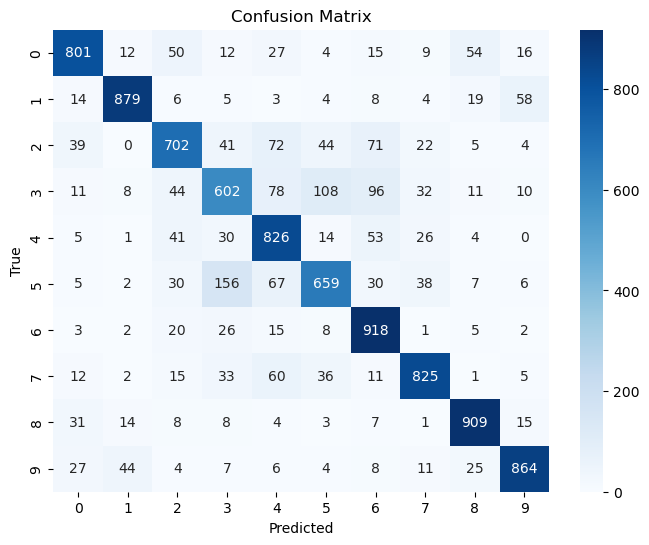

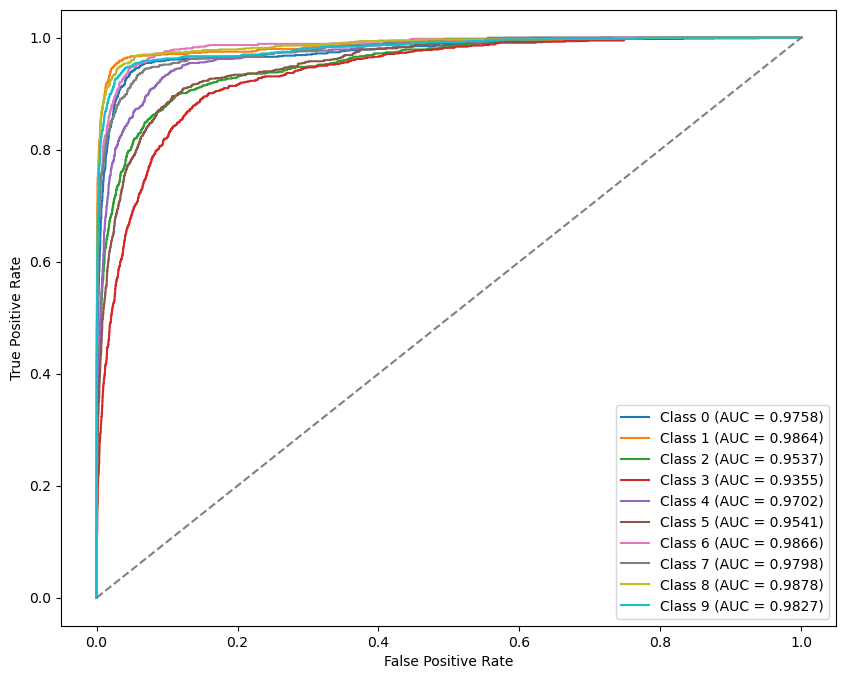

In [2]:
# Train and Evaluate CNN
print("Training CNN...")
train_model(cnn_model, train_dataset, epochs=epochs_cnn)
print("CNN Evaluation:")
evaluate_model(cnn_model, test_dataset)

Training MLP...
Train for 391 steps
Epoch 1/40
391/391 [==============================] - 11s 27ms/step - loss: 2.0958 - accuracy: 0.3311
Epoch 2/40
391/391 [==============================] - 9s 22ms/step - loss: 1.7445 - accuracy: 0.4097
Epoch 3/40
391/391 [==============================] - 9s 23ms/step - loss: 1.6047 - accuracy: 0.4497
Epoch 4/40
391/391 [==============================] - 9s 23ms/step - loss: 1.4930 - accuracy: 0.4812
Epoch 5/40
391/391 [==============================] - 9s 23ms/step - loss: 1.4046 - accuracy: 0.5094
Epoch 6/40
391/391 [==============================] - 8s 21ms/step - loss: 1.3316 - accuracy: 0.5314
Epoch 7/40
391/391 [==============================] - 8s 21ms/step - loss: 1.2590 - accuracy: 0.5591
Epoch 8/40
391/391 [==============================] - 8s 21ms/step - loss: 1.1943 - accuracy: 0.5783
Epoch 9/40
391/391 [==============================] - 8s 22ms/step - loss: 1.1396 - accuracy: 0.5979
Epoch 10/40
391/391 [==============================] -

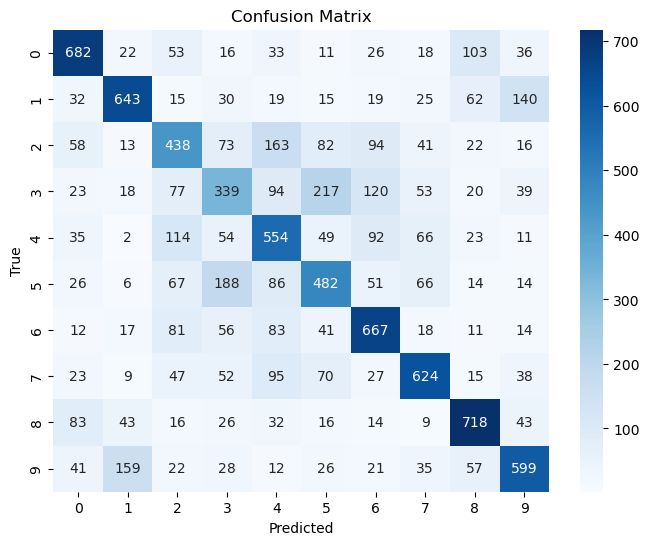

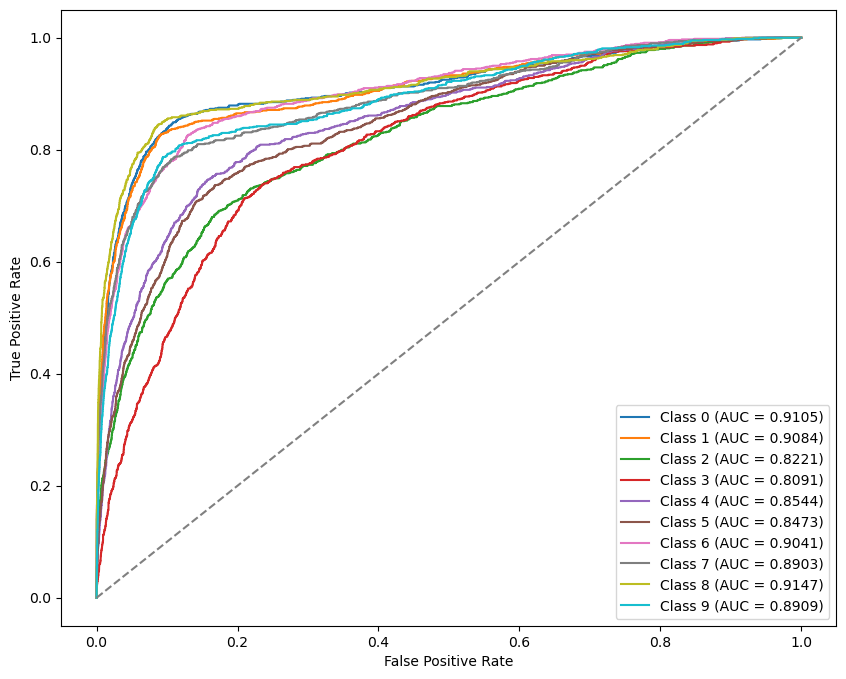

In [3]:
# Train and Evaluate MLP
print("Training MLP...")
train_model(mlp_model, train_dataset, epochs=epochs_mlp)
print("MLP Evaluation:")
evaluate_model(mlp_model, test_dataset)

## Hasil Tensorflow

Dari hasil train dan evaluasi dengan test untuk **CNN**, didapatkan:
1. **Training Time**: 8 menit 2 detik
2. **Train Accuracy akhir yang didapat**: 0.9140
3. **Test Accuracy akhir yang didapat**: 0.7985

Dari hasil train dan evaluasi dengan test untuk **MLP**, didapatkan:
1. **Training Time**: 6 menit 34 detik
2. **Train Accuracy akhir yang didapat**: 0.9207
3. **Test Accuracy akhir yang didapat**: 0.5746

Dari hasil dengan Tensorflow dan epoch 40 untuk CNN dan MLP, Test Accuracy CNN lebih tinggi dari MLP serta di atas 75%, Test Accuracy MLP masih di bawah minimum 75%. Untuk Test Metrics lain semuanya masih lebih tinggi CNN dibanding MLP.

# Penjelasan Persamaan Matematika dan Evaluasi

## Model: MLP (Multi-Layer Perceptron)
### Komponen MLP:
1. **Fully Connected (FC) Layers**: Setiap lapisan mengaplikasikan operasi linear:
   $$\text{z} = \text{Wx} + \text{b}$$
2. **ReLU Activation** untuk non-linearitas, sama seperti pada CNN.
3. **Dropout**: Regularisasi dengan menghilangkan node acak.
4. **BatchNorm**: Menormalkan input layer untuk mempercepat pelatihan.

## 3. Metrik Evaluasi
### 1. Accuracy
**Kegunaan**: Mengukur sejauh mana prediksi model secara keseluruhan benar.  
**Rumus**:
$$
\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}
$$

**Titik Bagus**: Biasanya, accuracy tinggi (>80%) adalah indikasi bahwa model bekerja dengan baik, namun perlu hati-hati dengan dataset yang tidak seimbang karena accuracy bisa menipu.


### 2. Precision
**Kegunaan**: Mengukur seberapa andal model saat memprediksi suatu kelas tertentu sebagai positif.  
**Rumus**:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

**Titik Bagus**: Precision tinggi (>70%) ideal untuk kasus di mana False Positives sangat berbahaya, seperti diagnosis penyakit langka atau deteksi penipuan.


### 3. Recall
**Kegunaan**: Mengukur kemampuan model untuk mendeteksi semua instance positif dalam data.  
**Rumus**:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

**Titik Bagus**: Recall tinggi (>70%) penting jika False Negatives lebih kritis, seperti pada sistem keamanan atau deteksi kebakaran.


### 4. F1 Score
**Kegunaan**: Merupakan rata-rata harmonis dari Precision dan Recall, memberikan keseimbangan ketika penting untuk memperhatikan keduanya.  
**Rumus**:
$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

**Titik Bagus**: Nilai F1 di atas 0.7 umumnya dianggap baik, terutama pada dataset yang tidak seimbang.


### 5. Area Under Curve (AUC)
**Kegunaan**: Mengukur kemampuan model untuk membedakan antara kelas positif dan negatif, dihitung dari ROC Curve.  
**Rumus (integral)**:
$$
\text{AUC}_{\text{ROC}} = \int_{0}^{1} \text{TPR}(\text{FPR}) \, d\text{FPR}
$$

**Titik Bagus**: AUC mendekati 1 menunjukkan model sangat baik dalam membedakan kelas; AUC di bawah 0.5 menandakan performa buruk (seperti tebak acak).


### Interpretasi Umum
- **Model yang baik** tidak hanya memiliki accuracy tinggi, tetapi juga keseimbangan antara precision, recall, dan F1.
- **Dataset tidak seimbang**: Fokus pada precision, recall, atau F1 daripada hanya bergantung pada accuracy.
- **AUC tinggi** menunjukkan model dapat diandalkan untuk membedakan kelas dengan baik, meski tidak sepenuhnya menangkap kesalahan spesifik seperti recall rendah.


## 4. Evaluasi Model
Hasil evaluasi menggunakan **Confusion Matrix** dan **ROC Curve**:
1. **Confusion Matrix**:
   - Baris: True class.
   - Kolom: Predicted class.
2. **ROC Curve** untuk setiap kelas:
   - Sumbu X: False Positive Rate (FPR).
   - Sumbu Y: True Positive Rate (TPR).

